### Imports

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from IPython.display import display,HTML

# Int cufflinks
# making all charts public and setting a global theme
cf.set_config_file(theme='solar',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
plt.style.use('dark_background')

### 01. Load the Dataset

In [3]:
def load_dataset(path:str) -> pd:
    return pd.read_csv(path)

In [4]:
# Loading data using pandas
path = './diabetes.csv'
dataset = load_dataset(path)
columns = list(dataset.columns)

### 02. Explorethe Dataset

In [5]:
# Explore the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Shows if there are any entries that are NA or NAN
dataset.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [7]:
#Plotting data
def plot_data(dataset):
    """Plot out all the data from the dataset in different histograms"""
    dataset.hist(bins=50, figsize = (20,15))
    plt.show()
    return


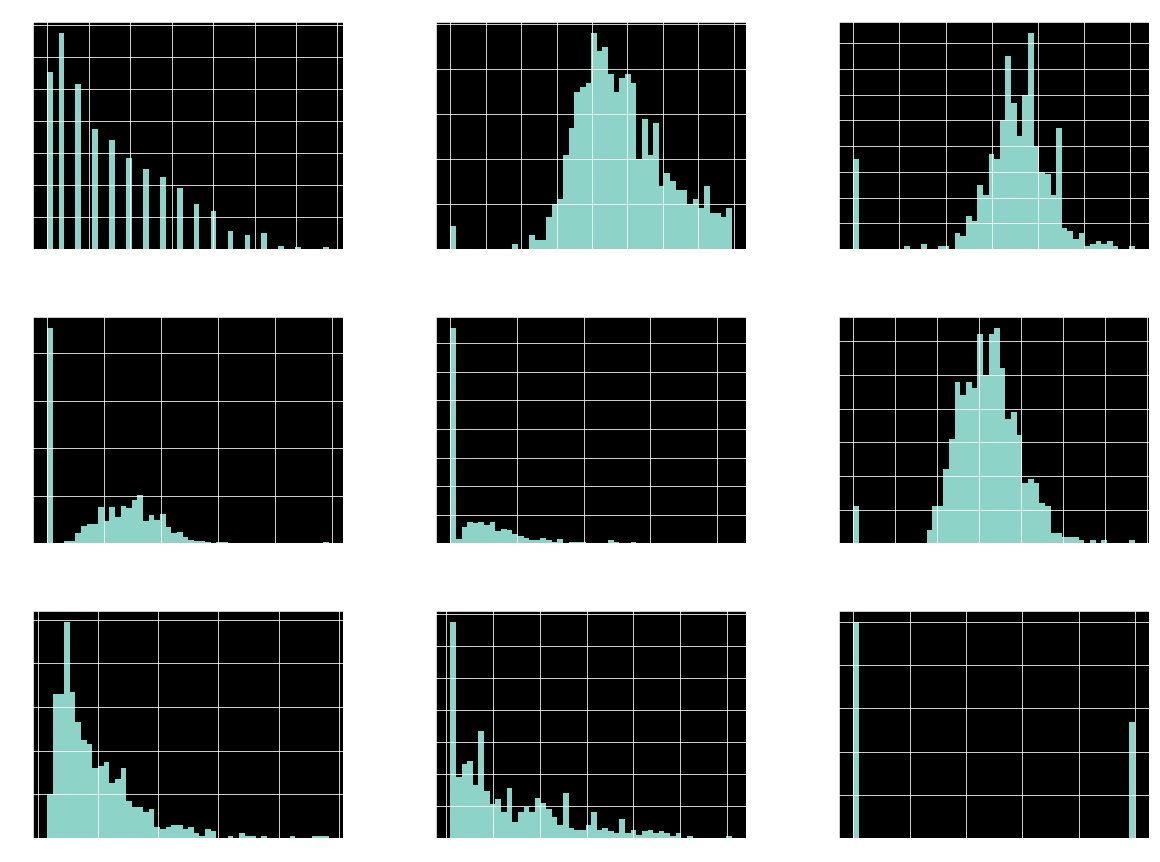

In [8]:
plot_data(dataset)

### 03. Correlation Matrix

<AxesSubplot:>

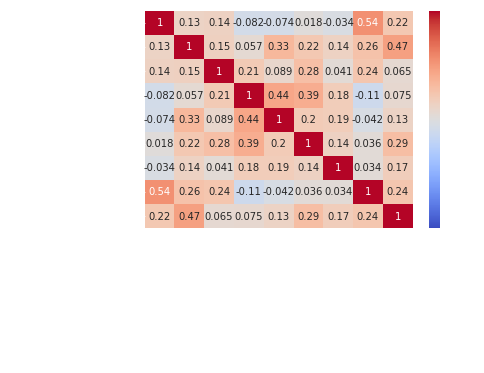

In [9]:
# Correlation data 
corr = dataset.corr()

# Correlation matrix with seaborn (correlation val are -1 to 1, thats why vmin vmax)
sns.heatmap(corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

No meaningful correlation found. All features are informative.

### Functions for Checking Parameters

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve

# Check AOC ARC curve
def aoc_arc_curve(pred, labels_test):
    """Plots the AOC ARC curve and score"""
    auc = roc_auc_score(labels_test, pred)
    print('AUROC score: {:.2f}'.format(auc))

    false_positive_rate, true_positive_rate, thresolds = roc_curve(labels_test, pred)

    plt.figure(figsize=(5, 4), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'y')
    
    plt.plot([0,1],[0,1], linestyle='dotted')

    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightyellow', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = {:.2f}'.format(auc), ha='right', fontsize=12, weight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    return auc

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    # Check accuracy
    accuracy = accuracy_score(labels_test , pred)

    # Check precision
    precision = precision_score(labels_test , pred)

    # Check recall
    recall = recall_score(labels_test , pred)

    # Check F1 score
    F1 = f1_score( labels_test , pred)

    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(F1))
    
    auc = aoc_arc_curve(pred, labels_test)
    
    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall, 'fi':F1, 'auc': auc}


### 04 Data Pre-processing

In [12]:
from sklearn.model_selection import train_test_split

# Create features and labels
features = dataset.drop(['Outcome'], axis=1)
labels = dataset['Outcome']

# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.25)

### 04.1 Scaling

In [14]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

### 04.2 Imputation

In [15]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(features_train_scaled)
features_train_imputated = imputer.transform(features_train_scaled)

imputer = imputer.fit(features_test_scaled)
features_test_imputated = imputer.transform(features_test_scaled)


### 04.3 Imablanced Data


#### Up-sampling  _(with `imblearn`)_

In [17]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Re-sizing the data 
features_train_balanced, labels_train_balanced = SMOTE().fit_resample(features_train_imputated, labels_train)
features_test_balanced, labels_test_balanced = SMOTE().fit_resample(features_test_imputated, labels_test)


#### Down-sampling  _(with `imblearn`)_

In [18]:
from imblearn.under_sampling import RandomUnderSampler

# Re-sizing the data 
rus = RandomUnderSampler(random_state=0)
features_train_balanced2, labels_train_balanced2 = rus.fit_resample(features_train_imputated, labels_train)
features_test_balanced2, labels_test_balanced2 = rus.fit_resample(features_test_imputated, labels_test)

## Parameter Comparison

In [30]:
def run_classifier(classifier, features_train, labels_train, features_test, labels_test) -> dict:
    # Fit data for training into classifier
    classifier.fit(features_train , labels_train)
    # Predicting with classifier
    pred = classifier.predict(features_test)
    return parameter_check(pred, labels_test)

In [31]:
def compare_parameters(classifier):
    raw_param = run_classifier(classifier, features_train, labels_train, features_test, labels_test)
    scaled_param = run_classifier(classifier, features_train_scaled, labels_train, features_test_scaled, labels_test)
    imputed_param = run_classifier(classifier, features_train_imputated, labels_train, features_test_imputated, labels_test)
    upsamp_param = run_classifier(classifier, features_train_balanced, labels_train_balanced, features_test_balanced, labels_test_balanced)
    downsamp_param = run_classifier(classifier, features_train_balanced2, labels_train_balanced2, features_test_balanced2, labels_test_balanced2)

    # Plot out different parameters
    compare = [raw_param, scaled_param, imputed_param, downsamp_param, upsamp_param]
    headers_comparison = ['Raw', 'Scaled', 'Imputed', 'Down-sampling (Imblearn)', 'Up-sampling (Imblearn)']

    # Create dataframe for parameter comparison
    compare_df = pd.DataFrame(compare)
    compare_df["results"]=headers_comparison
    compare_df = compare_df.set_index('results', drop=True).rename_axis(None)

    # Plot
    compare_df.iplot(kind='bar', width=0.9)


## 05. Pipeline

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, Lasso

from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

In [55]:
def build_pipeline(params, classifier, clf='clf'):
    # Setting up a pipeline
    pipe = Pipeline([
        ('scaler', None),
        ('imputer', SimpleImputer(missing_values=0)),
        ('upsampler', None),
        ('downsampler', None),
        (clf, classifier)
    ])

    # Cross validation
    skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

    # Set up the grid search
    gs = GridSearchCV(pipe,params,n_jobs=-1,cv=skf)

    # Fit gs to training data
    gs_results = gs.fit(features_train, labels_train)

    # Find best fit
    print(f'Best score: {gs_results.best_score_}')
    print(f'Best parameters: \n{gs_results.best_params_}')
    # Get score
    print(f'\nScore: {gs.score(features_test, labels_test)}')

    # Predict results
    labels_preds = gs.predict(features_test)
    best_par = parameter_check(labels_preds, labels_test)

    return best_par

### KNN Classifier - Parameter Comparison

Accuracy: 0.74
Precision: 0.73
Recall: 0.51
F1 score: 0.60
AUROC score: 0.70


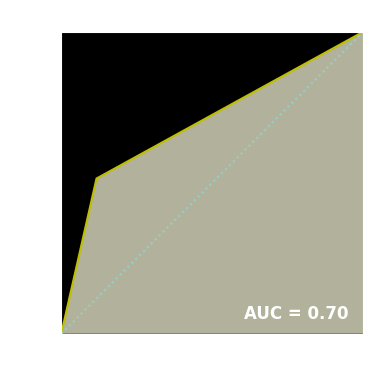

Accuracy: 0.78
Precision: 0.78
Recall: 0.56
F1 score: 0.65
AUROC score: 0.73


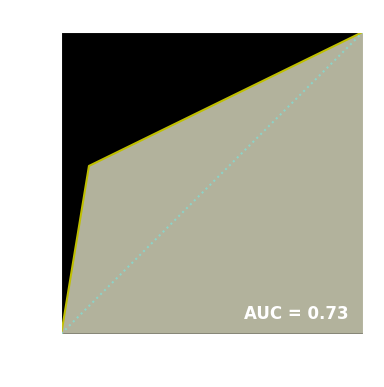

Accuracy: 0.78
Precision: 0.78
Recall: 0.56
F1 score: 0.65
AUROC score: 0.73


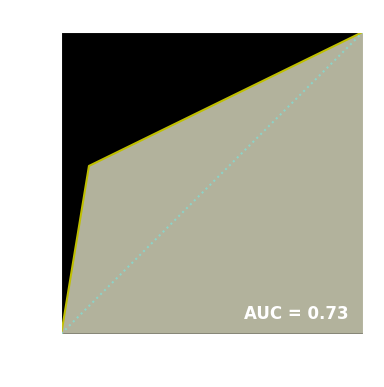

Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F1 score: 0.76
AUROC score: 0.76


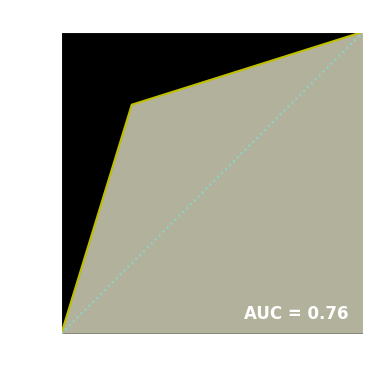

Accuracy: 0.76
Precision: 0.78
Recall: 0.72
F1 score: 0.75
AUROC score: 0.76


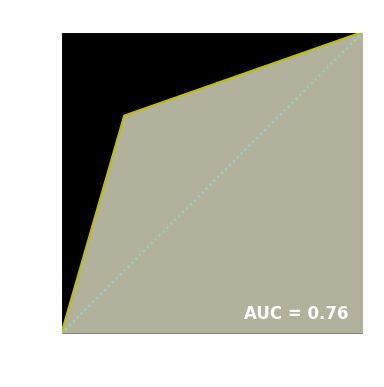

In [47]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN Classifier
classifier = KNeighborsClassifier(n_neighbors=5)
# Run parameter comparison
compare_parameters(classifier)

### KNN Classifier - Pipeline

Best score: 0.7604497751124437
Best parameters: 
{'clf__metric': 'minkowski', 'clf__n_neighbors': 13, 'clf__weights': 'uniform', 'downsampler': 'passthrough', 'imputer__strategy': 'median', 'scaler': MinMaxScaler(), 'upsampler': 'passthrough'}

Score: 0.75
Accuracy: 0.75
Precision: 0.74
Recall: 0.51
F1 score: 0.61
AUROC score: 0.70


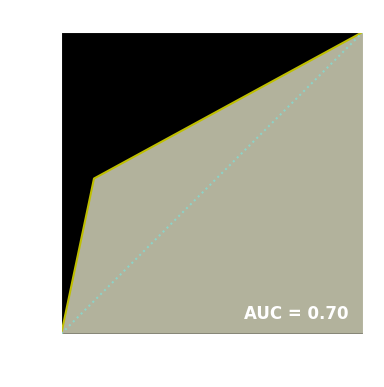

In [51]:
# Parameter grid to search over using grid search
params={
    'imputer__strategy': ['mean', 'median'],
    'upsampler': ['passthrough',
                  RandomOverSampler(random_state=42),
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0)
                 ],
    'downsampler':['passthrough',
                   RandomUnderSampler(random_state=42),
                   TomekLinks()
                  ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'clf__n_neighbors':[3,5,7,9,11,13],
    'clf__weights':['uniform', 'distance'],
    'clf__metric': ['minkowski', 'manhattan', 'euclidian']
}

best_par_knn = build_pipeline(params, KNeighborsClassifier())

### SVM Classifier - Parameter Comparison

Accuracy: 0.78
Precision: 0.89
Recall: 0.46
F1 score: 0.61
AUROC score: 0.71


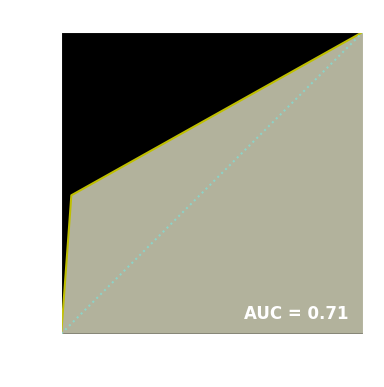

Accuracy: 0.75
Precision: 0.75
Recall: 0.50
F1 score: 0.60
AUROC score: 0.70


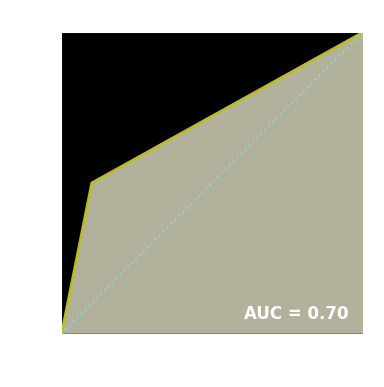

Accuracy: 0.75
Precision: 0.75
Recall: 0.50
F1 score: 0.60
AUROC score: 0.70


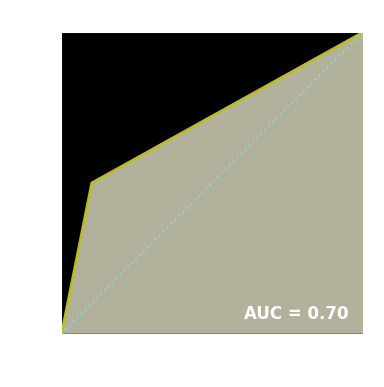

Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 score: 0.77
AUROC score: 0.77


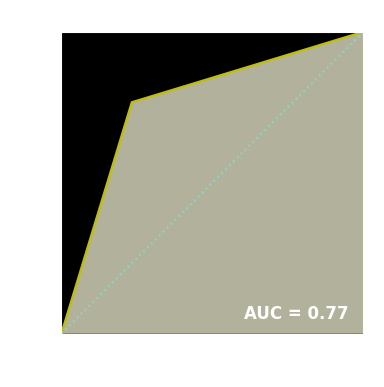

Accuracy: 0.76
Precision: 0.76
Recall: 0.75
F1 score: 0.76
AUROC score: 0.76


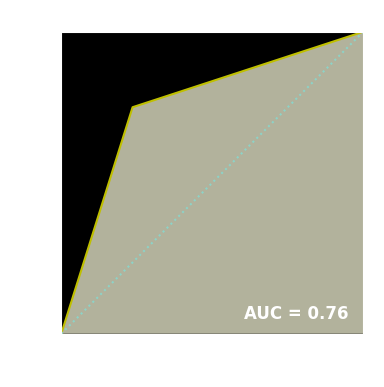

In [49]:
from sklearn.svm import SVC
# Create SVC Classifier
classifier = SVC()
# Run parameter comparison
compare_parameters(classifier)

### SVM Classifier - Pipeline

In [57]:
# Parameter grid to search over using grid search
params={
    'imputer__strategy': ['mean', 'median'],
    'upsampler': ['passthrough', 
                  RandomOverSampler(random_state=42), 
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0)
                 ],
    'downsampler':['passthrough', 
                   RandomUnderSampler(random_state=42),
                   TomekLinks()
                  ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'svc__degree':[0.001, 0.01, 0.1, 1, 10],
    'svc__gamma' : [1,2,3,4,5],
    'svc__kernel' :['rbf', 'linear', 'poly' ,'sigmoid']
}

In [ ]:
best_par_svm = build_pipeline(params, SVC(), 'svc')

### Algorithm Comparison

In [ ]:
# Plot out different parameters
compare = [best_par_knn, best_par_svm]
headers_comparison = ['KNN', 'SCV']

In [ ]:
compare_df = pd.DataFrame(compare)
compare_df["results"]=headers_comparison
compare_df = compare_df.set_index('results', drop=True).rename_axis(None)

In [ ]:
compare_df.iplot(kind='bar', width=0.9)